# Can we design an algorithm to spot active Minecraft players?

**Group 004-008**

Atlas **Danks** **(59825927)**,
Isabelle **He** **(26923540)**,
Aisa **Rafiei** **(80157365)**,
Steven **Weng** **(95102919)**.

## Introduction and Background Information

PLAI, the Pacific Laboratory for Artificial Intelligence, is a research lab at the University of British Columbia which is currently aiming to create artificially intelligent NPCs capable of playing the video game Minecraft. To accomplish this, they have created a custom server from which they can collect data on how players of Minecraft interact throughout the game’s world. 
One question that is relevant to their study is **which kinds of players are most likely to contribute the most data** to their research, something which could be measured by metrics such as the number of `hours played`. To answer this, our own research question was whether we could clearly define “good players” as a category from the data they have given us and create an algorithm that could accurately predict whether an individual player would contribute a significant amount.


To analyze this question, we used the `players.csv` file. This file lists all players who have signed up, as well as their `gender`, `age`, self-reported `experience` level, whether they have subscribed to the PLAIcraft email listing, as well as how many hours they have played. We also added `sessions` column from the `sessions.csv` data set.

## Data Description
The data is organized into two datasets, `players.csv` and `sessions.csv`, containing data on individual players and their individual sessions respectively. 

**Players data**

The players dataset has **196 observations**, corresponding to 196 players, and **9 variables**: 
* `Experience (fct)`: The player’s self-reported experience level in minecraft from a list of five categories. The most popular experience category was “Amateur”, with 32.1% of players reporting themselves as it. The next most popular category was “Veteran”, being reported by 24.5% of players.


* `subscribe (lgl)`: Whether the player has subscribed to PLAIcraft email updates. A majority of players have subscribed, with 73.4% of players clicking the “YES” option.


* `hashedEmail (chr)`: An anonymized version of the player’s email code. This variable is shared with the sessions.csv data, so in spite of anonymity it is possible to get a full picture of each individual’s playing history. 


* `played_hours (dbl)`: The number of hours each individual has played on the server. One challenge with this data is that 43.9% of our sample have not spent any time on the server, and only 9.6% have completed the required three hours or more of play.


* `name (chr)`: A nickname chosen by each player from a randomized list upon account creation. 


* `gender (fct)`: The player’s reported gender. 63.3% of our players are male, 18.9% of our players are female, 5.6% players chose not to say anything, and 12.1% of our players chose another gender option. 


* `age (int)`: The player’s reported age. The average age is 21.3 years old, and the median age is 19. For the sake of visualization purposes, our histogram has filtered out any significant outliers. 
There are two additional variables, that being individualId and organizationName. These variables have no data, and appear to have been wiped blank for player privacy. 

**Sessions data**

The `sessions.csv` dataset has **1535 observations**, each of which comprises a single play session by a player. This file contains **5 variables**, them being:
* `hashedEmail (chr)`: an anonymized hash code of the player’s email. Shared with players.csv.


* `start_time (dttm)`: The date and time of the beginning of the player’s session.


* `end_time (dttm)`: The date and time of the end of the player’s session.


* `original_start_time (dbl)`: the start time encoded into Unix time. 


* `original_end_time (dbl)`: the end time encoded into Unix time. 


In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(themis)
library(yardstick)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Data Wrangling and Tidying

**Combining datasets**:

For this project, we first combined our two files into one document in order to get an accurate picture of how many `sessions` each player played on the server. To do this, we first summarized the session data in `sessions.csv` to get a total amount of sessions per player, and then combined it with the `players.csv` data through checking the hashed email codes shared by the two files.

**Removing suspicious data**:

Finally, we removed any data from our file that seemed suspicious or unusual, in order to make sure any inaccurate samples did not skew our whole. Luckily, except for a small handful of suspicious answers for the `age` category, there was little that needed to be filtered out (> 90).

In [2]:
#Reading in data and basic tidying

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(players_url)

sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(sessions_url)

sessions_per_player <- sessions_data |>
group_by(hashedEmail) |>
summarize(sessions = n()) |>
arrange(-sessions) 

combined_data <- left_join(players_data, sessions_per_player, by = "hashedEmail")

modified_data <- combined_data |>
  mutate(gender = as_factor(gender))

clean_data <- modified_data |>
    select(- individualId, -organizationName) |>
    filter(age <90)
clean_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,sessions
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,1


In [3]:
# Assigning labels: Good (1h+ played) vs Bad (<1h played) contributor

# As a 0/1 variable
clean_data$over1 <- as.numeric(clean_data$played_hours >= 1)

# Examine new variable
table(clean_data$over1, useNA = "ifany")


# Check range of original variable at levels of new
tapply(clean_data$played_hours, clean_data$over1, range)



# As a factor
clean_data$over1_fac <- factor(clean_data$over1,
                            levels = 0:1,
                            labels = c("<1h", ">1h"))

# Examine new variable
table(clean_data$over1_fac, useNA = "ifany")


# Check range of original variable at levels of new
tapply(clean_data$played_hours, clean_data$over1_fac, range)


#Final wrangling of the data!
labelled_data <- clean_data |>
    select(-over1) |>
    mutate(contributor_type = fct_recode(over1_fac, "Bad" = "<1h", "Good" = ">1h")) |>
    select(-over1_fac) |>
    mutate(sessions = if_else(is.na(sessions), 0, sessions)) #Changing sessions "NA" to 0 sessions
labelled_data


  0   1 
152  42 

$`0`
[1] 0.0 0.9

$`1`
[1]   1.0 223.1


<1h >1h 
152  42 

$`<1h`
[1] 0.0 0.9

$`>1h`
[1]   1.0 223.1

experience,subscribe,hashedEmail,played_hours,name,gender,age,sessions,contributor_type
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,Good
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,Good
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,Bad
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,Bad
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,Bad
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,0,Bad
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,0,Bad
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1,Bad
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,1,Bad


In [4]:
#splitting the data

set.seed(3456)
data_split <- initial_split(labelled_data, prop = 0.75, strata = experience)
training_data <- training(data_split)
testing_data <- testing(data_split)

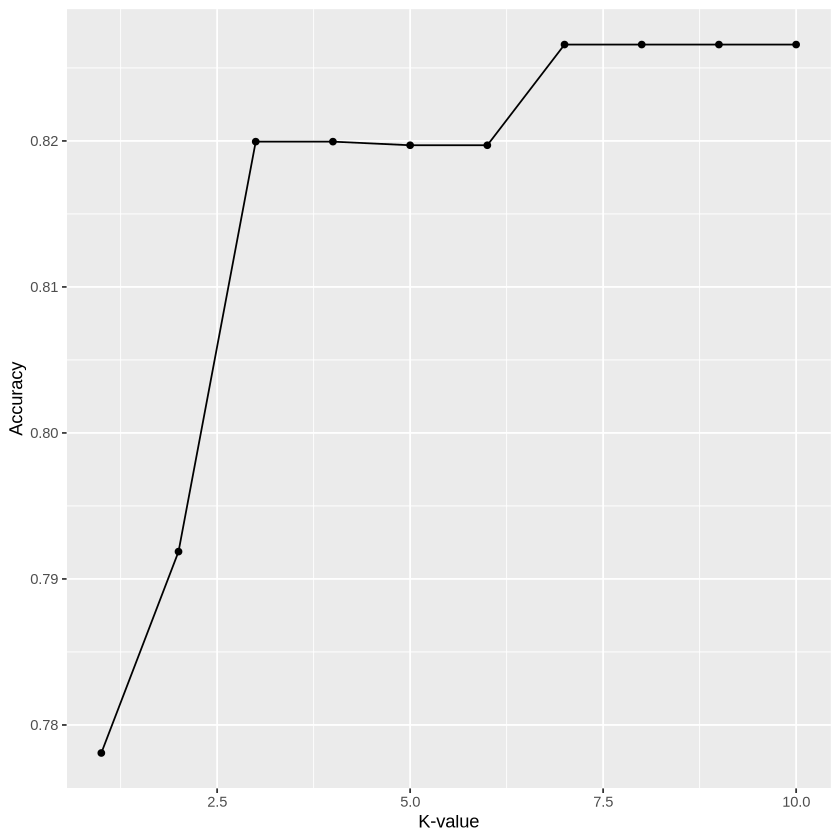

In [5]:
# Creating the model with tuning and cross-validation: Choosing the optimal k-value

set.seed(3456)

classification_recipe <- recipe(contributor_type ~ subscribe + age + sessions + gender, 
                          data = training_data) |>
    step_scale(age, sessions) |>
    step_center(age, sessions)

classification_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
			set_engine("kknn") |>
			set_mode("classification")


data_vfold <- vfold_cv(training_data, v = 5, strata = contributor_type)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))


metrics <- workflow() |>
        add_recipe(classification_recipe) |>
        add_model(classification_knn) |>
        tune_grid(resamples = data_vfold, grid = k_vals) |>
        collect_metrics() |>
        filter(.metric == "accuracy")
#metrics


cross_val_plot <- ggplot(metrics, aes(x= neighbors, y= mean)) +
    geom_point() +
    geom_line() +
    labs(x= "K-value", y= "Accuracy")
cross_val_plot

In [8]:
# Building the tuned model with k = 7

tuned_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
			set_engine("kknn") |>
			set_mode("classification")

tuned_fit <- workflow() |>
    add_recipe(classification_recipe) |>
    add_model(tuned_knn) |>
    fit(data = training_data)
#tuned_fit

predictions <- predict(tuned_fit, testing_data) |>
    bind_cols(testing_data)
#predictions

tuned_accuracy <- predictions |>
        metrics(truth = contributor_type, estimate = .pred_class) |>
        filter(.metric == "accuracy")
tuned_accuracy 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.78


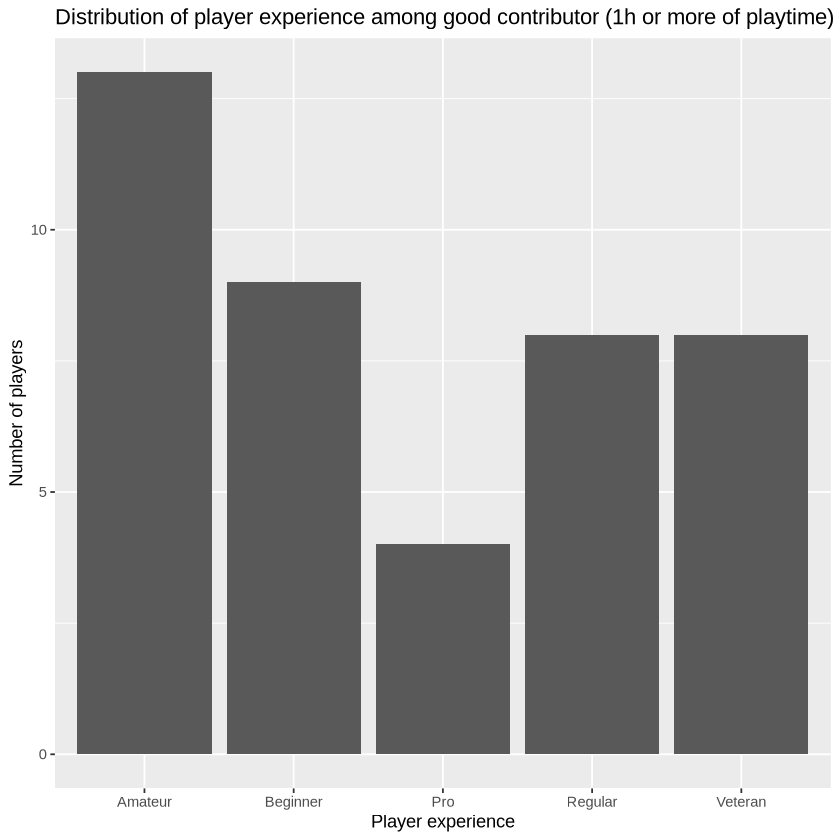

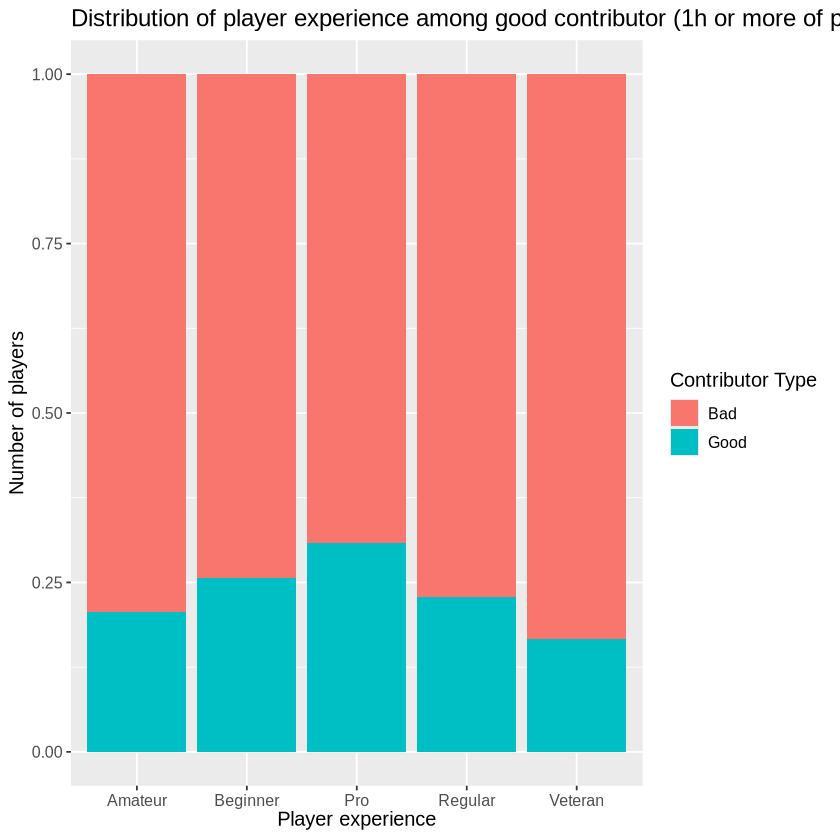

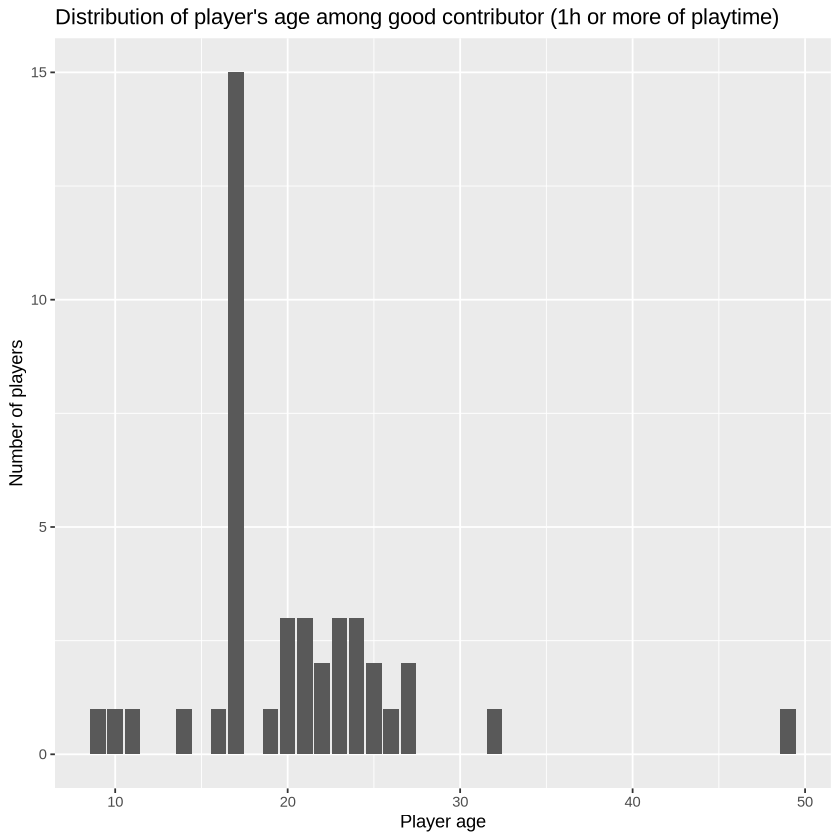

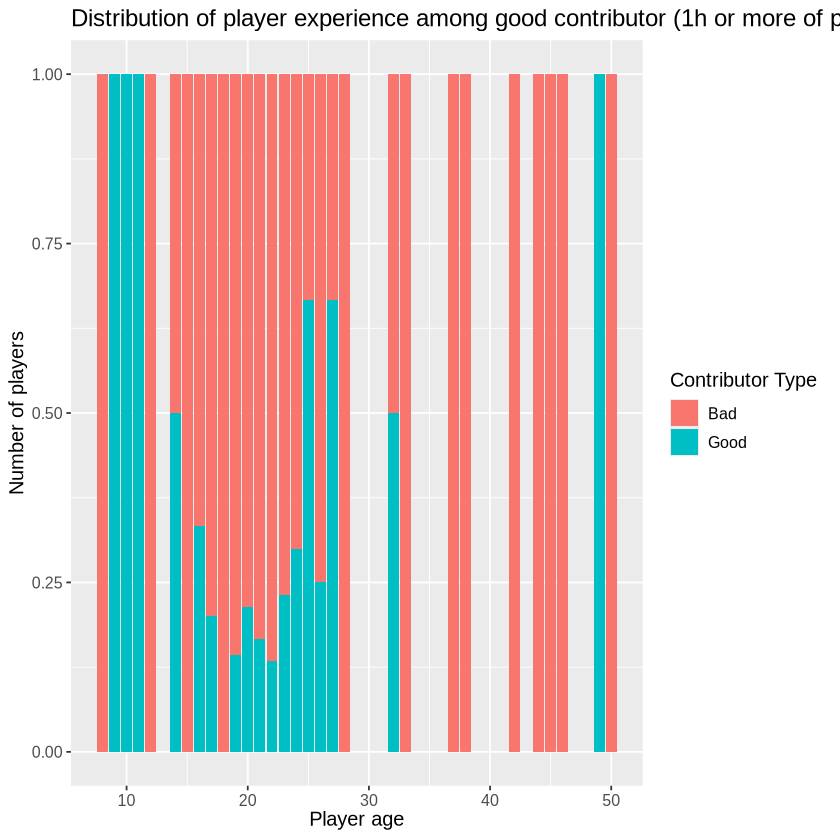

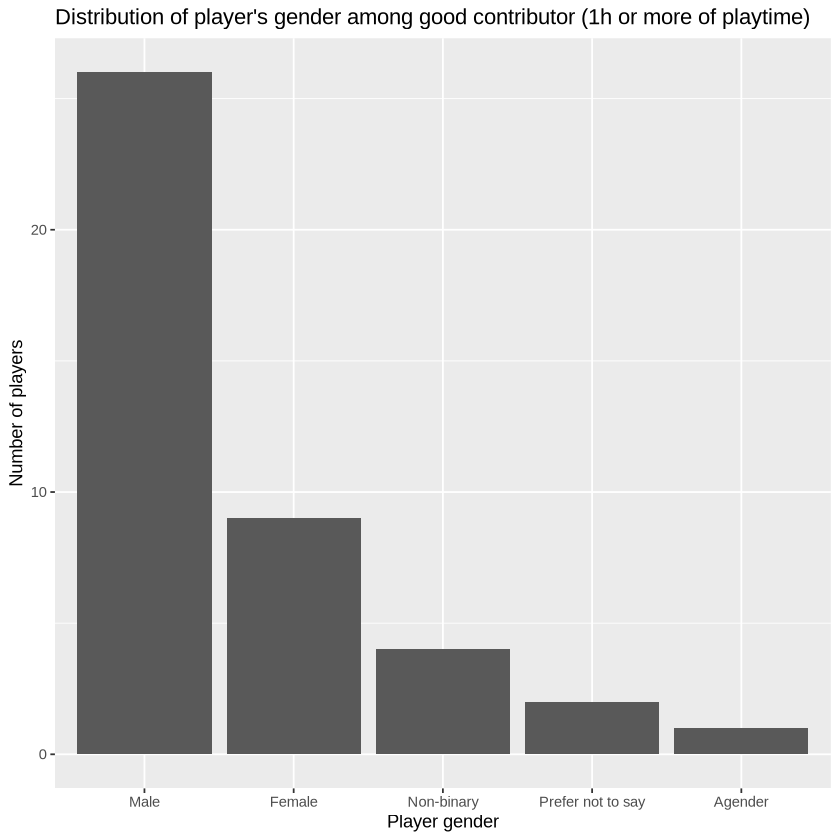

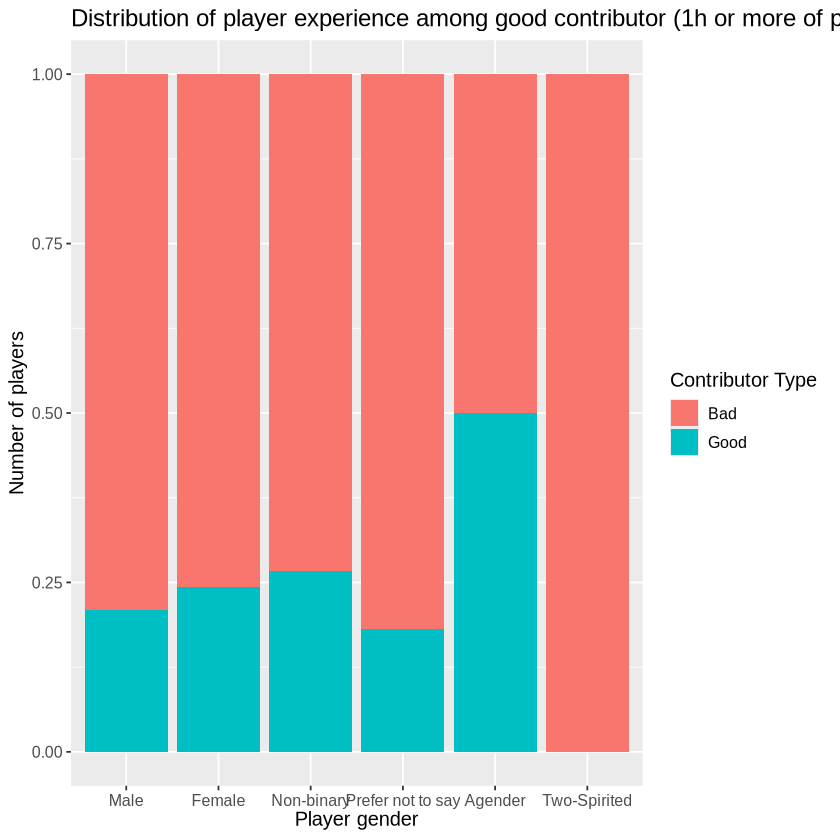

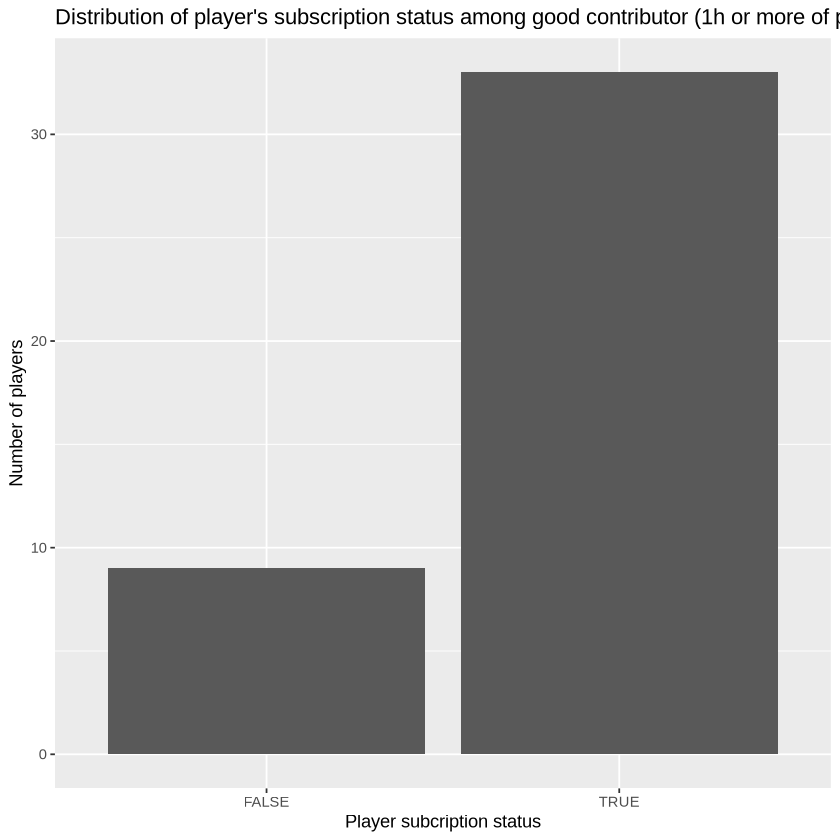

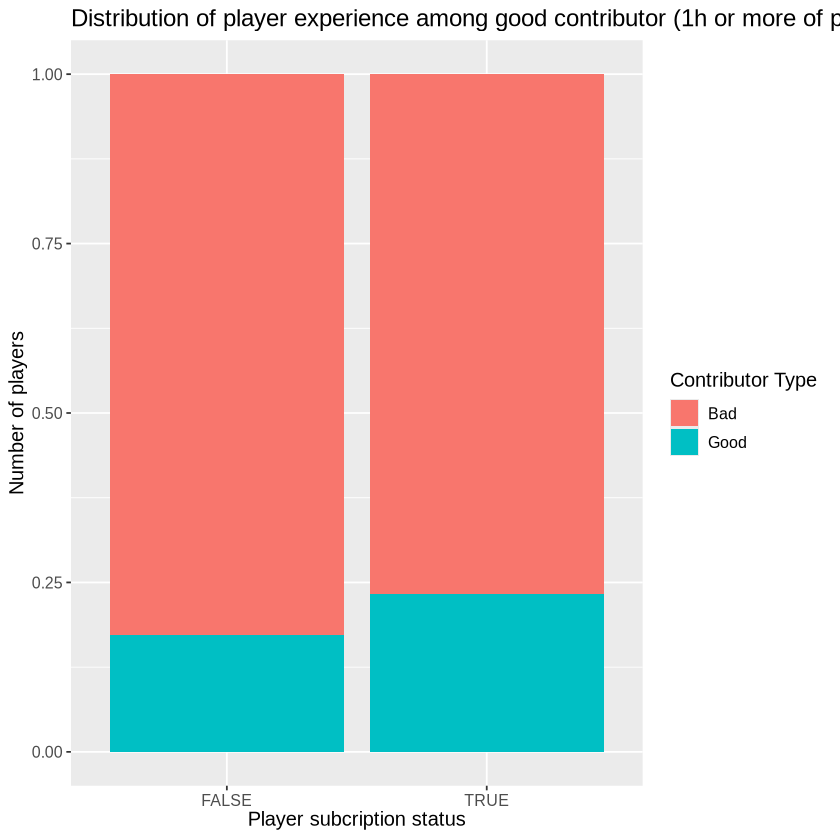

In [7]:
# Visualizations exploring the characteristics of "good" contributors

good_contributors <- labelled_data |>
    filter(contributor_type == "Good")
#good_contributors


# 1. EXPERIENCE

goodcontributors_experience <- good_contributors |>
    group_by(experience) |>
    count()
#goodcontributors_experience

experience_plot <- goodcontributors_experience |>
    ggplot(aes(x= experience, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player experience", y= "Number of players", title= "Distribution of player experience among good contributor (1h or more of playtime)")
experience_plot

#percentage
ggplot(labelled_data, aes(x = experience, fill = contributor_type)) +
geom_bar(stat = "count", position = "fill") +
labs(x= "Player experience", y= "Number of players", fill = "Contributor Type", title= "Distribution of player experience among good contributor (1h or more of playtime)") +
theme(text = element_text(size = 12))

# 2. age

goodcontributors_age <- good_contributors |>
    group_by(age) |>
    count()
#goodcontributors_age

age_plot <- goodcontributors_age |>
    ggplot(aes(x= age, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player age", y= "Number of players", title= "Distribution of player's age among good contributor (1h or more of playtime)")
age_plot

#percentage
ggplot(labelled_data, aes(x = age, fill = contributor_type)) +
geom_bar(stat = "count", position = "fill") +
labs(x= "Player age", y= "Number of players", fill = "Contributor Type", title= "Distribution of player experience among good contributor (1h or more of playtime)") +
theme(text = element_text(size = 12))

# 3. GENDER

goodcontributors_gender <- good_contributors |>
    group_by(gender) |>
    count()
#goodcontributors_gender

gender_plot <- goodcontributors_gender |>
    ggplot(aes(x= gender, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player gender", y= "Number of players", title= "Distribution of player's gender among good contributor (1h or more of playtime)")
gender_plot

#percentage
ggplot(labelled_data, aes(x = gender, fill = contributor_type)) +
geom_bar(stat = "count", position = "fill") +
labs(x= "Player gender", y= "Number of players", fill = "Contributor Type", title= "Distribution of player experience among good contributor (1h or more of playtime)") +
theme(text = element_text(size = 12))

# 4. SUBSCRIBE

goodcontributors_sub <- good_contributors |>
    group_by(subscribe) |>
    count()
#goodcontributors_sub

sub_plot <- goodcontributors_sub |>
    ggplot(aes(x= subscribe, y= n)) +
    geom_bar(stat= "identity") +
    labs(x= "Player subcription status", y= "Number of players", title= "Distribution of player's subscription status among good contributor (1h or more of playtime)")
sub_plot

#Percentage
ggplot(labelled_data, aes(x = subscribe, fill = contributor_type)) +
geom_bar(stat = "count", position = "fill") +
labs(x= "Player subcription status", y= "Number of players", fill = "Contributor Type", title= "Distribution of player experience among good contributor (1h or more of playtime)") +
theme(text = element_text(size = 12))

